In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import random
import time

# IA - Labyrinth

In [53]:
WIDTH = 40
HEIGHT = 40
WALL_RATIO = 0.3
MAX_TIME_S = 5

In [75]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [140]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [276]:
def load_grid(grid_file):
    grid = np.load(grid_file)
    h = grid.shape[0]
    w = grid.shape[1]
    return (grid, (h, w))

In [277]:
# grid, START_CELL, END_CELL = generate_labyrinth(WIDTH, HEIGHT, WALL_RATIO)
grid, size = load_grid("grids/grid10.npy")
START_CELL = (0,0)
END_CELL = (size[0]-1,size[1]-1)

No solution has been found


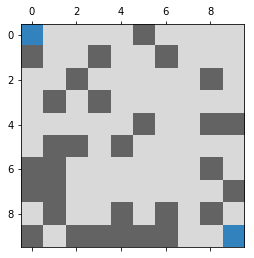

In [278]:
display_labyrinth(grid, START_CELL, END_CELL)

# Data Structure

In [309]:
# In this example, we fix the number of directions to 4
class Direction(Enum):
    TOP = 0#, "t", np.array([-1, 0]))
    RIGHT = 1#, "r", np.array([0, 1]))
    BOTTOM = 2#, "b", np.array([1, 0]))
    LEFT = 3#, "l", np.array([0, -1]))
    
    def apply(self, location):
        return location + self.move
    
    def to_str(self):
        self.string
    
    def get_move(self):
        return self._tbl[self]
    
    def opposite(self):
        return Direction((self.value+2)%4)

Direction._tbl = {
    Direction.TOP: (-1, 0),
    Direction.RIGHT: (0, 1),
    Direction.BOTTOM: (1, 0),
    Direction.LEFT: (0, -1)
}

NB_DIRECTIONS = len(Direction)
# CHROMOSOME_LENGTH_START = (size[0]+size[1])*2-1
CHROMOSOME_LENGTH_START = int((WALL_RATIO*size[0]*size[1]))

## Generic tools

In [310]:
def available_direction(location, previous_locations):
    temp_directions = set()
    directions = set()
    
    if location[0] > 0:
        temp_directions.add(Direction.TOP)
    if location[0] < size[0]-1:
        temp_directions.add(Direction.BOTTOM)
    if location[1] > 0:
        temp_directions.add(Direction.LEFT)
    if location[1] < size[1]-1:
        temp_directions.add(Direction.RIGHT)
    
    for direction in temp_directions:
        location_new = tuple(np.add(location, direction.get_move()))
        if grid[location_new] != 1.0 and location_new not in previous_locations:
            directions.add(direction)
    
    return directions

In [311]:
def validate_individual(individual, start_location, targeted_location):
    new_individual = []
    previous_locations = [start_location]
    location = start_location
    direction = None
    
    for direction in individual:
        # Validate every direction in an individual
        directions = available_direction(location, previous_locations)
        
        if len(directions) == 0:
            # Check if we are stuck
            return new_individual, previous_locations
        
        if direction not in directions:
            # Find another valid direction
            direction = random.sample(directions,1)[0]
        
        # Compute new location
        location = tuple(np.add(location, direction.get_move()))
        
        new_individual.append(direction)
        previous_locations.append(location)
        
        if location == targeted_location:
            return new_individual, previous_locations
    return new_individual, previous_locations

In [312]:
def compute_direction_to_path(individual, start_location):
    locations = [start_location]
    location = start_location
    for direction in individual:
        location = tuple(np.add(location, direction.get_move()))
        locations.append(location)
    return locations

In [313]:
def evaluate(individual, start_location, targeted_location):
    individual, locations = validate_individual(individual, start_location, targeted_location)
    
    # Add coefficient for length of the path
    score = len(individual)
    
    # Add double coefficient for Manhattan distance
    # TODO Improve
    locations = compute_direction_to_path(individual, start_location)
    distance = tuple(np.subtract(locations[-1], targeted_location))
    manhattan_distance = abs(distance[0])+abs(distance[1])
    
    return score + 2*manhattan_distance, individual

In [314]:
def init_individual(length):
    individual = []
    for i in range(0, length):
        individual.append(random.choice(list(Direction)))
    return individual

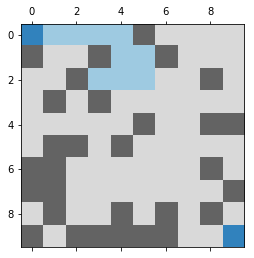

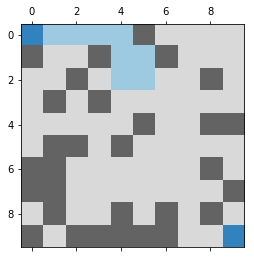

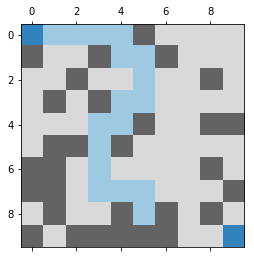

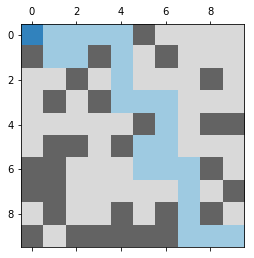

In [315]:
min_ = 100
for i in range(0,20):
    ind = init_individual(CHROMOSOME_LENGTH_START)
    
    score, ind = evaluate(ind, START_CELL, END_CELL)
    
    locations = compute_direction_to_path(ind, START_CELL)
    if score < min_:
        min_ = score
        display_labyrinth(grid, START_CELL, END_CELL, locations)

## Deap Framework

In [221]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import operator
from enum import Enum
from collections import namedtuple
import random
import time

In [222]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [234]:
toolbox.register("fitness", fitness)
toolbox.register("individual", init_individual, CHROMOSOME_LENGTH_START)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selRoulette)
toolbox.register("evaluate", evaluate)

In [224]:
population = toolbox.population(300)
elites = tools.HallOfFame(1)

In [317]:
res = algorithms.eaSimple(population, toolbox, 0.7, 0.1, 40, halloffame=elites, verbose=False)

AttributeError: 'list' object has no attribute 'fitness'

### Fitnesse

A prendre en compte: 
    -Validité chemin
    - Intégrité
    - Qualité
    - Des approche
    - Temps

No solution has been found


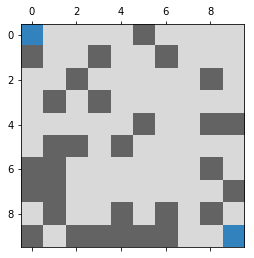

In [93]:
display_labyrinth(grid, START_CELL, END_CELL)

### Crossover

update after cross over

- recursive

In [150]:
def crossover(ind1,ind2):
    # Def cross point
    cxpoint = random.randint(1,min(len(ind1),len(ind2)))
    
    # Generate new individuals
    ind3, ind4 = validate_individual(ind1[:cxpoint]+ind2[cxpoint:]), validate_individual(ind2[:cxpoint]+ind1[cxpoint:])
    
    # Keep all of them
    
    pass

# toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mate", crossover)
toolbox.register("select", tools.selRoulette)

### Mutation

Ne pas revenir en arrière
Probabilité de mutation identique partout ?
- récursive

In [320]:
def test(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

return population, logbook

NameError: name 'logbook' is not defined

In [208]:
def mutate2(individual, probability):
    # Foreachgene
    
    # random mutate
    
    # make individual valid
    
    
    pass

## Interface

In [235]:
def solve_labyrinth(grid, start_cell, end_cell, max_time_s):
    start_time = inter_time = time.time()
    population = toolbox.population(n=50)

    # crossover probability
    CXPB = 0.7

    # mutation probability (of a chromosome)
    # compare with the indpb=0.1 in the previous line toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    MUTPB = 0.2
    
    toolbox.evaluate(population, start_cell, end_cell)
    solution = None

    number_of_iterations = 0
    while len(find_winners(population)) == 0 and inter_time - start_time < max_time_s:
        children = toolbox.select(population, len(population))

        # Full alternative ---
        # Clone the selected individuals, 
        children = list(map(toolbox.clone, children))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)            

        for mutant in children:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)

        # ---
        # Shorcut alternative ---
        #children = algorithms.varAnd(offspring, toolbox, 0.7, 0.2)
        # ---

        evaluate_population(children, TARGET)
        population = children

        # Search for the solution
        fitnesses = [ind.fitness.values[0] for ind in population]
        min_fit = min(fitnesses)
        best = population[fitnesses.index(min_fit)]
        if not solution or best.fitness.values[0] < solution.fitness.values[0]:
            solution = best

        inter_time = time.time()

        number_of_iterations += 1

    duration = time.time() - start_time

    # TODO 4 :) In which case the following line is executed?
    if not solution:
        solution = find_winners(population)[0]
    
    display_labyrinth(grid, start_cell, end_cell, solution)

In [316]:
grid, size = load_grid("grids/grid40.npy")
start_cell = np.array([0,0])
end_cell = (size[0]-1,size[1]-1)

solve_labyrinth(grid, start_cell, end_cell, MAX_TIME_S)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()